In [1]:
%matplotlib notebook

import re
import torch
import fnmatch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

from network import Network
from hessian import Hessian
from utils import get_mean_std
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import DataLoader
from subset_dataset import get_subset_dataset
from models import model_urls, download_model

In [2]:
#%% Parameters

dataset = 'CIFAR10'

net = 'VGG11_bn'

lr = '[0p01342773722529442]'

examples_per_class = 13

num_classes = 10

epoch = 256

batch_size = 1024

In [3]:
#%% Model and its meta data

# Model path
model_path = 'dataset=' + dataset                             \
           + '-net=' + net                                    \
           + '-lr=' + lr                                      \
           + '-examples_per_class=' + str(examples_per_class) \
           + '-num_classes=' + str(num_classes)               \
           + '-epc_seed=0'                                    \
           + '-train_seed=0'                                  \
           + '-forward_class=Classification'                  \
           + '-epoch=' + str(epoch)                           \
           + '.pth'

# Read CSV
df = pd.read_csv('training_results.csv')

# First row in CSV, which contains different parameters
row = df.iloc[0]

In [4]:
#%% Network

# Initialize network
model = Network().construct(net, row)
model = model.eval()

# Load trained model
state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict, strict=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of parameters: ', total_params)

Total number of parameters:  28157706


In [5]:
#%% Dataset

# Transform
mean, std = get_mean_std(dataset)
pad = int((row.padded_im_size-row.im_size)/2)
transform = transforms.Compose([transforms.Pad(pad),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)])

# Subsampled dataset
full_dataset = getattr(datasets, dataset)
subset_dataset = get_subset_dataset(full_dataset=full_dataset,
                                    examples_per_class=examples_per_class,
                                    epc_seed=row.epc_seed,
                                    root='data/',
                                    train=True,
                                    transform=transform,
                                    download=True)

# Loader
loader = DataLoader(dataset=subset_dataset,
                    drop_last=False,
                    batch_size=batch_size)

Files already downloaded and verified


LanczosApproxSpec
Estimating spectrum range


100%|██████████| 64/64 [00:28<00:00,  2.22it/s]


Estimated spectrum range:
[-20.875449065323533	829.3914774341399]
Spectrum range after adding margin:
[-63.38879539029671	871.9048237591131]
Approximating spectrum


100%|██████████| 256/256 [01:55<00:00,  2.23it/s]


<IPython.core.display.Javascript object>


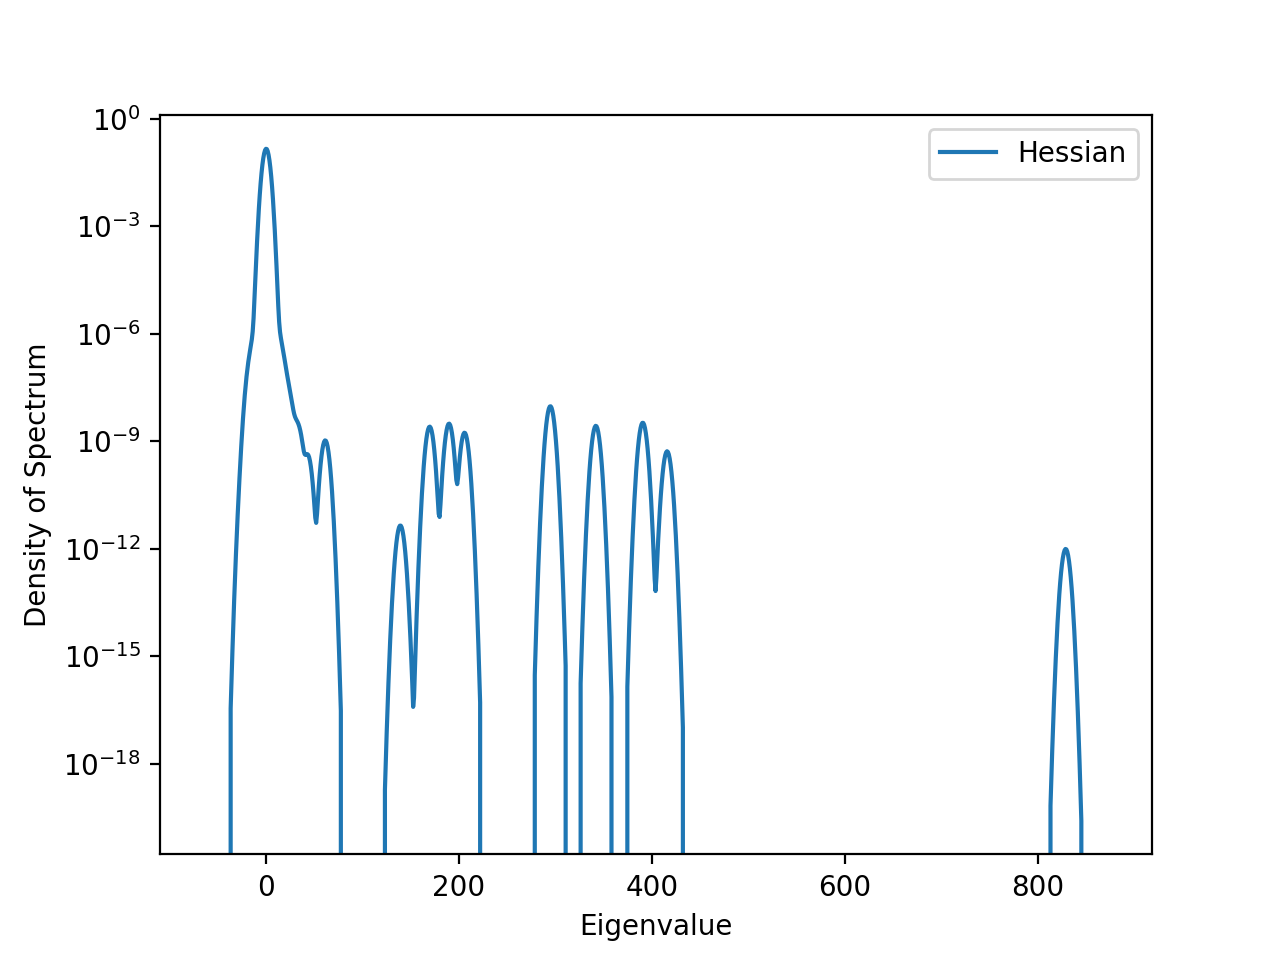

Text(0,0.5,'Density of Spectrum')

In [6]:
#%% Approximate the spectrum of the Hessian using LanczosApproxSpec
Hess = Hessian(loader=loader,
               model=model,
               hessian_type='Hessian',
               )

Hess_eigval, \
Hess_eigval_density = Hess.LanczosApproxSpec(init_poly_deg=64, # iterations used to compute spectrum range
                                             poly_deg=256)     # the higher the parameter the better the approximation

plt.figure()
plt.semilogy(Hess_eigval, Hess_eigval_density, label='Hessian')
plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Density of Spectrum')

SubspaceIteration


100%|██████████| 128/128 [09:53<00:00,  4.60s/it]


LanczosApproxSpec
Estimating spectrum range


100%|██████████| 64/64 [00:31<00:00,  2.06it/s]


Estimated spectrum range:
[-20.870396576126126	43.02175906025187]
Spectrum range after adding margin:
[-24.065004357945025	46.21636684207077]
Approximating spectrum


100%|██████████| 256/256 [02:04<00:00,  2.07it/s]


<IPython.core.display.Javascript object>


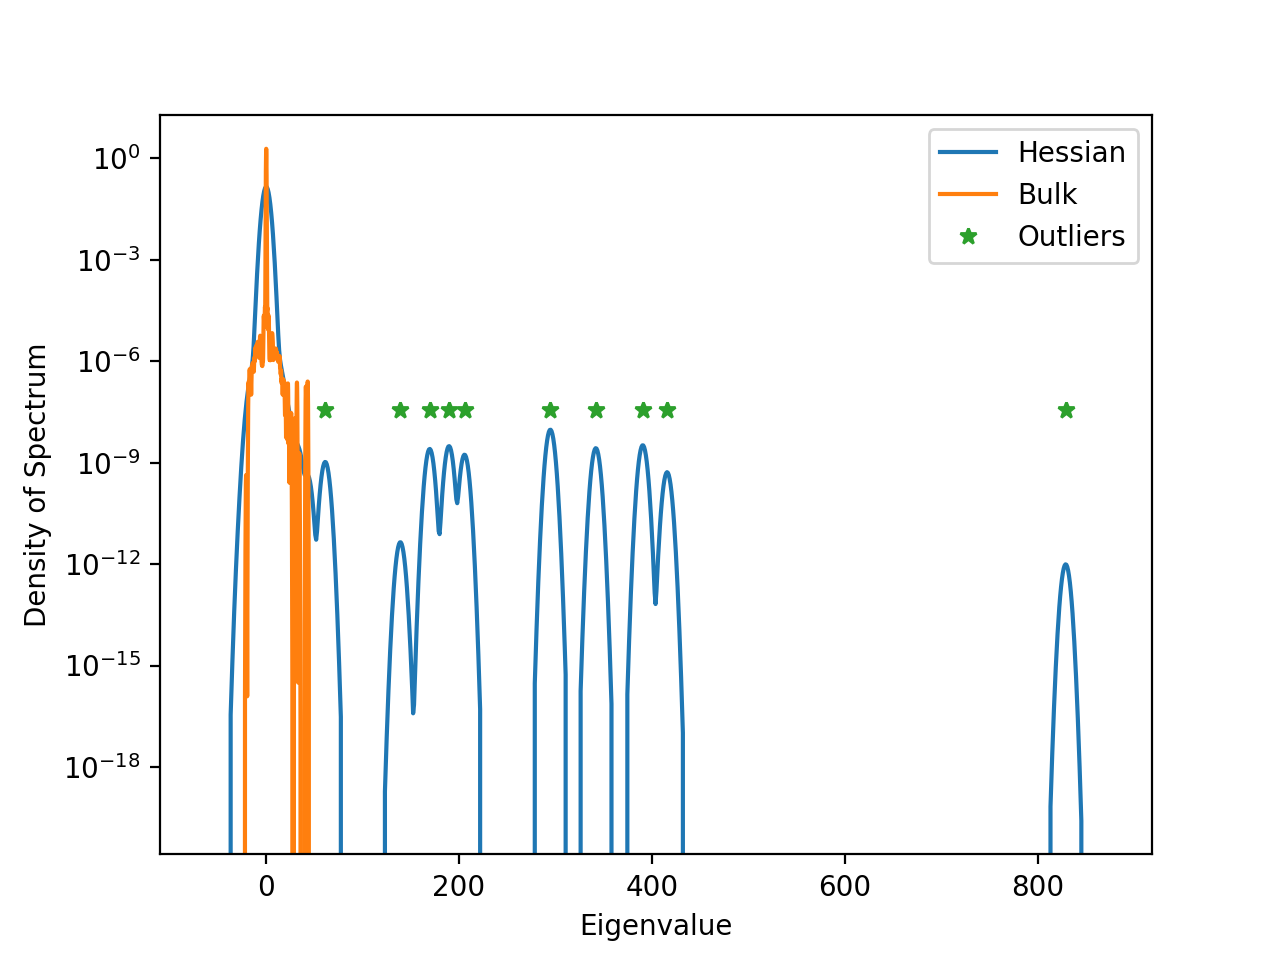

Text(0,0.5,'Density of Spectrum')

In [7]:
# #%% Approximate the spectrum of the Hessian using SubspaceIteration and LanczosApproxSpec

Hess = Hessian(loader=loader,
               model=model,
               hessian_type='Hessian')

# Subspace iteration
Hess.vecs, \
Hess.vals, \
_ = Hess.SubspaceIteration(row.num_classes, # rank of subspace
                           iters=128,       # iterations of subspace iteration
                          )

# Approximate spectrum of Hessian - \sum_i val_i vec_i vec_i^T
Hess_bulk_eigvals, Hess_bulk_eigval_density = Hess.LanczosApproxSpec(init_poly_deg=64, poly_deg=256)

plt.figure()

plt.semilogy(Hess_eigval, Hess_eigval_density, label='Hessian')
plt.semilogy(Hess_bulk_eigvals, Hess_bulk_eigval_density, label='Bulk')
plt.semilogy(Hess.vals, np.ones(len(Hess.vals)) / total_params, '*', label='Outliers')

plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Density of Spectrum')

In [8]:
#%% Approximate the spectrum of G using SubspaceIteration and LanczosApproxSpec

G = Hessian(loader=loader,
            model=model,
            hessian_type='G', # notice the change here
            )

# Subspace iteration
G.vecs, \
G.vals, \
_ = G.SubspaceIteration(row.num_classes,
                        iters=128)

# Approximate spectrum of G - \sum_i val_i vec_i vec_i^T
G_bulk_eigvals, G_bulk_eigval_density = G.LanczosApproxSpec(init_poly_deg=64, poly_deg=256)

SubspaceIteration


100%|██████████| 128/128 [11:30<00:00,  5.37s/it]


LanczosApproxSpec
Estimating spectrum range


100%|██████████| 64/64 [00:37<00:00,  1.72it/s]


Estimated spectrum range:
[-0.08762394194241718	43.744385493338115]
Spectrum range after adding margin:
[-2.279224413706444	45.93598596510214]
Approximating spectrum


100%|██████████| 256/256 [02:28<00:00,  1.70it/s]


In [9]:
#%% Approximate the spectrum of H using LanczosApproxSpec

H = Hessian(loader=loader,
            model=model,
            hessian_type='H', # notice the change here
            )

# Approximate spectrum of Hessian - \sum_i val_i vec_i vec_i^T
H_eigvals, H_eigval_density = H.LanczosApproxSpec(init_poly_deg=64, poly_deg=256)

LanczosApproxSpec
Estimating spectrum range


100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


Estimated spectrum range:
[-30.724865586277502	28.895992976504026]
Spectrum range after adding margin:
[-33.70590851441658	31.8770359046431]
Approximating spectrum


100%|██████████| 256/256 [02:20<00:00,  1.81it/s]


<IPython.core.display.Javascript object>


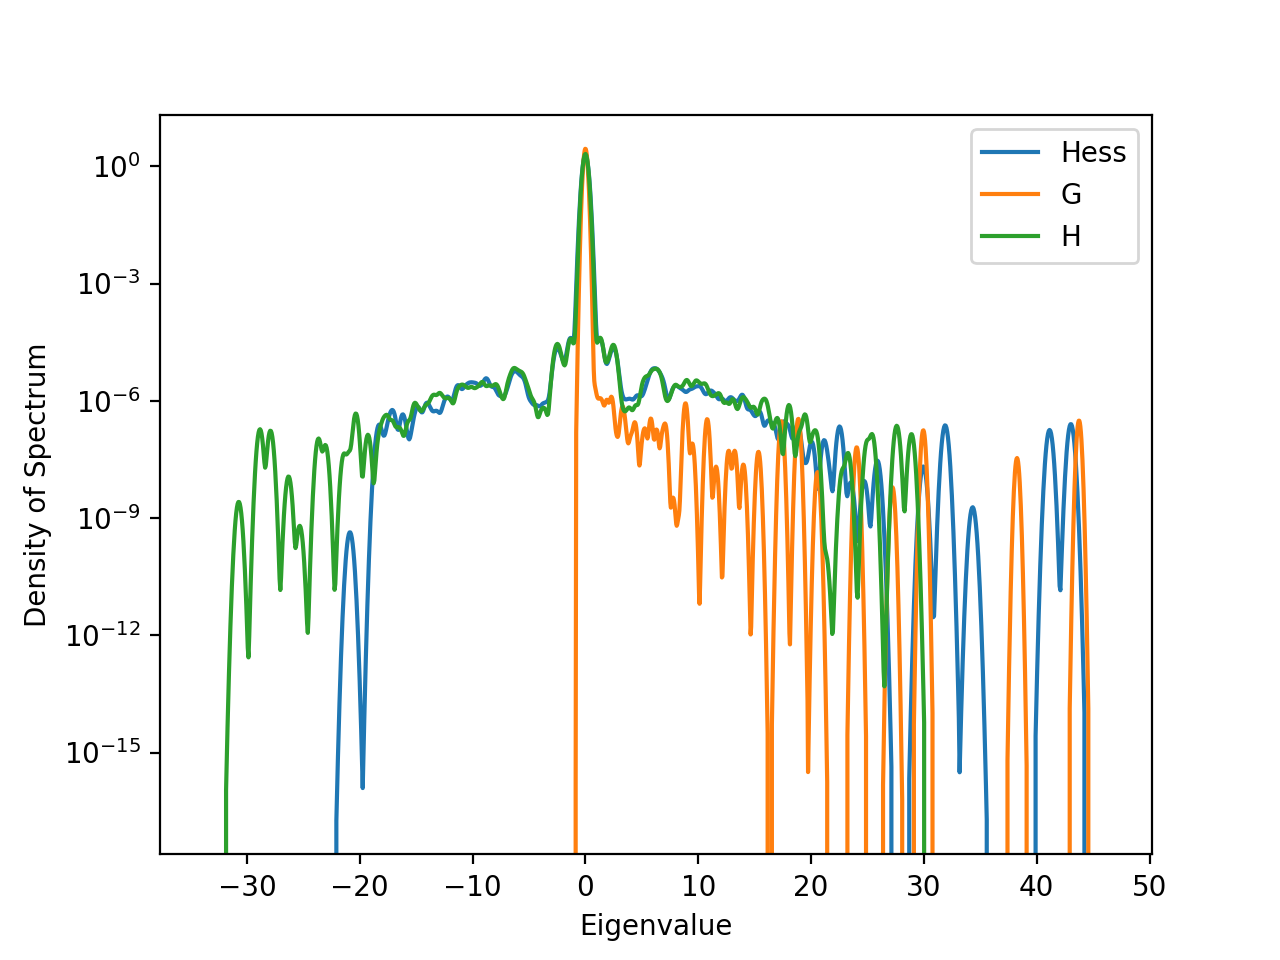

Text(0,0.5,'Density of Spectrum')

In [10]:
#%% Plot the spectra of Hess, G and H

plt.figure()

plt.semilogy(Hess_bulk_eigvals, Hess_bulk_eigval_density, label='Hess')
plt.semilogy(G_bulk_eigvals, G_bulk_eigval_density, label='G')
plt.semilogy(H_eigvals, H_eigval_density, label='H')

plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Density of Spectrum')

In [11]:
#%% Three-level hierarchical decomposition of G

res = Hessian(loader=loader,
              model=model,
              num_classes=row.num_classes,
              hessian_type='G',
              ).compute_G_decomp()

Computing G decomposition
Computing {delta_{c,c'}}_{c,c'}
Iteration: [1/1]


100%|██████████| 100/100 [00:53<00:00,  1.90it/s]


In [12]:
#%% Approximate the spectrum of log(G) using SubspaceIteration and LanczosApproxSpec

# Recall we already computed the top-C subspace of G

# Approximate the spectrum of log(G - \sum_i val_i vec_i vec_i^T)
log_G_bulk_eigvals, log_G_bulk_eigval_density = G.LanczosApproxSpec(init_poly_deg=64,
                                                                    poly_deg=2048,     # notice the higher degree
                                                                    log_hessian=True,
                                                                    eps=1e-6, # log(abs(eigval) + eps)
                                                                    )

LanczosApproxSpec
Estimating spectrum range


100%|██████████| 64/64 [00:35<00:00,  1.80it/s]


Estimated spectrum range:
[-0.04665151807901857	43.7446310243087]
log spectrum range:
[-13.815510557964274	3.778368908688552]
Spectrum range after adding margin:
[-14.695204531296914	4.658062882021193]
Approximating spectrum


100%|██████████| 2048/2048 [18:51<00:00,  1.80it/s]


In [13]:
#%% Compute traces of B_1

_, eigs = Hessian(loader=loader,
                  model=model,
                  num_classes=row.num_classes,
                  hessian_type='G',
                  ).compute_traces_B1(delta_ccp=res['delta_ccp'],
                                      iters=64, # iterations used to approximate trace
                                      )

# traces is a two-dimensional array
# sum over the second index corresponding to c'
eigs_summed = [sum(x) for x in eigs]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing traces of B_{1,c,c'}


100%|██████████| 64/64 [01:52<00:00,  1.77s/it]


<IPython.core.display.Javascript object>


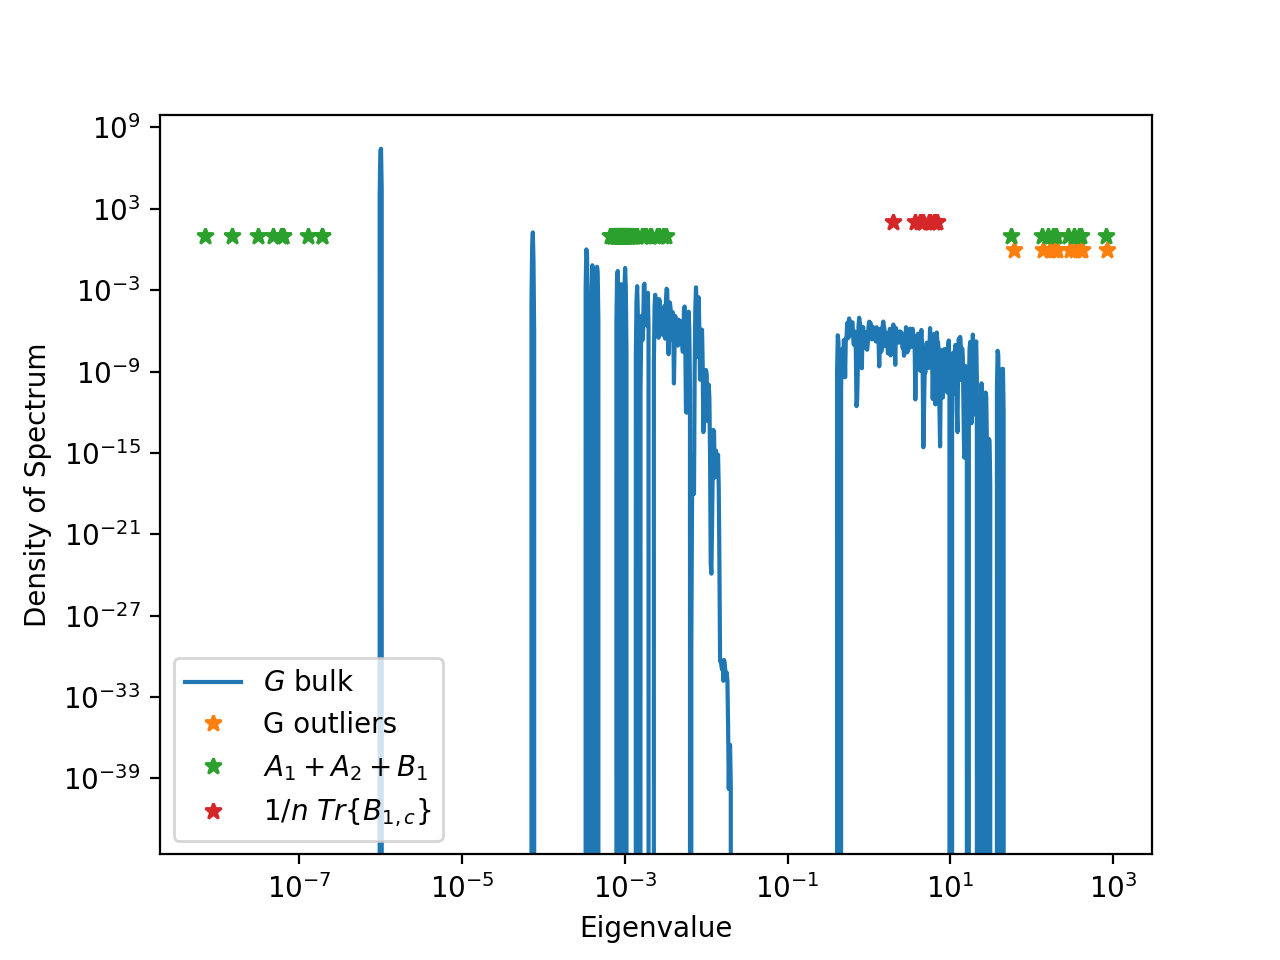

Text(0,0.5,'Density of Spectrum')

In [14]:
#%% Plot the spectrum of log(G) and its three-level hierarchical decomposition

plt.figure()

plt.loglog(log_G_bulk_eigvals, log_G_bulk_eigval_density, label='$G$ bulk')

plt.loglog(G.vals, np.ones(len(G.vals)), '*', label='G outliers')

plt.loglog(res['eigval'], np.ones(len(res['eigval'])) * 10, '*', label='$A_1+A_2+B_1$')

plt.loglog(eigs_summed, np.ones(len(eigs_summed)) * 100, '*', label='$1/n \ Tr\{ B_{1,c} \}$')

plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Density of Spectrum')